In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

import datetime

In [2]:
df = pd.read_csv('../data/interim/salary_skill_cleaned.csv')
df.head()

,Unnamed: 0,occupation,skill,importance,location,state,salary
0,0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [3]:
skills = df.pivot_table(values='importance',index=['occupation', 'location', 'salary'],columns='skill').reset_index()
skills.head()

skill,occupation,location,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
0,Accountants and Auditors,Abilene,70550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
1,Accountants and Auditors,Aguadilla-Isabela,29630.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
2,Accountants and Auditors,Akron,75550.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
3,Accountants and Auditors,Albany,63940.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
4,Accountants and Auditors,Albany,70280.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75


In [4]:
skills = skills.groupby('occupation').mean()
skills['salary'] = skills['salary'].round()
skills.head()

skill,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
occupation,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,71805.0,3.31,3.94,3.44,3.06,3.88,1.00,1.00,1.00,2.88,...,1.88,3.00,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
Actuaries,113659.0,3.38,4.00,4.00,3.00,4.25,1.00,1.00,1.00,3.00,...,2.12,2.88,2.88,3.88,3.88,4.00,1.75,3.12,1.00,3.38
Acute Care Nurses,72974.0,3.75,4.00,3.75,3.75,4.00,1.00,1.88,1.00,3.38,...,3.00,4.00,4.00,4.00,3.00,3.00,2.00,3.12,2.00,3.50
Adapted Physical Education Specialists,63093.0,4.00,4.00,3.25,3.50,3.88,1.00,1.12,1.00,4.12,...,1.50,3.88,4.00,4.00,3.00,3.12,1.88,3.12,1.88,3.88
Adhesive Bonding Machine Operators and Tenders,37034.0,2.62,3.12,2.75,3.00,2.88,2.88,2.12,1.12,2.25,...,1.50,2.25,2.88,3.12,2.75,2.12,1.25,3.00,3.00,2.75


In [5]:
skills.shape

(788, 36)

In [6]:
df['occupation'].nunique()

788

# Train/Test Split

In [7]:
len(skills) * .7, len(skills) * .3

(551.5999999999999, 236.39999999999998)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(skills.drop(columns='salary'), 
                                                    skills.salary, test_size=0.3, 
                                                    random_state=47)

In [9]:
X_train.shape, X_test.shape

((551, 35), (237, 35))

In [10]:
y_train.shape, y_test.shape

((551,), (237,))

In [11]:
X_train.dtypes

skill
Active Learning                      float64
Active Listening                     float64
Complex Problem Solving              float64
Coordination                         float64
Critical Thinking                    float64
Equipment Maintenance                float64
Equipment Selection                  float64
Installation                         float64
Instructing                          float64
Judgment and Decision Making         float64
Learning Strategies                  float64
Management of Financial Resources    float64
Management of Material Resources     float64
Management of Personnel Resources    float64
Mathematics                          float64
Monitoring                           float64
Negotiation                          float64
Operation and Control                float64
Operations Analysis                  float64
Operations Monitoring                float64
Persuasion                           float64
Programming                          float64
Qual

In [12]:
X_test.dtypes

skill
Active Learning                      float64
Active Listening                     float64
Complex Problem Solving              float64
Coordination                         float64
Critical Thinking                    float64
Equipment Maintenance                float64
Equipment Selection                  float64
Installation                         float64
Instructing                          float64
Judgment and Decision Making         float64
Learning Strategies                  float64
Management of Financial Resources    float64
Management of Material Resources     float64
Management of Personnel Resources    float64
Mathematics                          float64
Monitoring                           float64
Negotiation                          float64
Operation and Control                float64
Operations Analysis                  float64
Operations Monitoring                float64
Persuasion                           float64
Programming                          float64
Qual

# Baseline Model

In [13]:
# Use the mean as a baseline model
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[62959.04174229]])

In [14]:
# Predictions, train and test
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = dumb_reg.predict(X_test)

In [15]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -4.297963529520388e-07)

In [16]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(23507.949124014744, 22684.56981169642)

In [17]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1023621185.5862792, 942844576.68727)

# Linear Regression

In [18]:
# Linear Regression
lm = LinearRegression().fit(X_train, y_train)

In [19]:
# Predictions, train and test
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [20]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6275500498577504, 0.5775426500016854)

In [21]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(13255.480445502024, 14316.348756342988)

In [22]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(381247659.5361601, 398311450.13477826)

# Pipeline

In [23]:
pipeline = make_pipeline(SelectKBest(f_regression), LinearRegression())

In [24]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001CEBC1D8700>)),
                ('linearregression', LinearRegression())])

In [25]:
y_tr_pred = pipeline.predict(X_train)
y_te_pred = pipeline.predict(X_test)

In [26]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.5948695683156657, 0.5198437981646085)

In [27]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(13721.421961260405, 15186.280308806314)

In [28]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(414700092.7977992, 452712476.2890859)

In [29]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

# Cross Validation

In [30]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [31]:
lr_grid_cv = GridSearchCV(pipeline, param_grid=grid_params, cv=5, n_jobs=-1)

In [32]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001CEBC1D8700>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [33]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [34]:
lr_grid_cv.best_params_

{'selectkbest__k': 10}

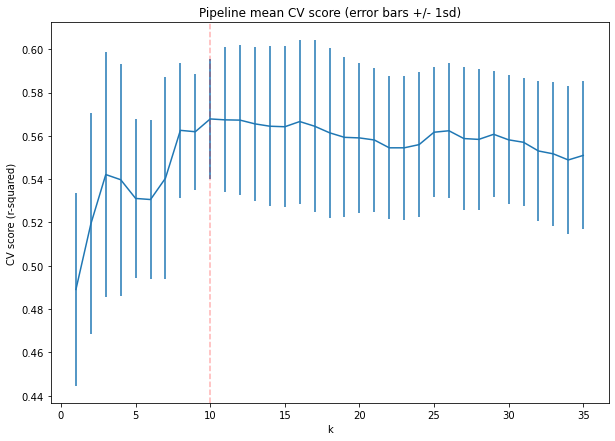

In [35]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.3)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [36]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [37]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important

skill
Judgment and Decision Making    22361.724853
Critical Thinking               11136.753746
Science                          8778.275990
Reading Comprehension            6673.395682
Complex Problem Solving          5522.791029
Operations Analysis              4879.607832
Systems Evaluation               3747.652365
Active Learning                  3467.680367
Systems Analysis                -5402.563305
Writing                         -7455.783661
dtype: float64

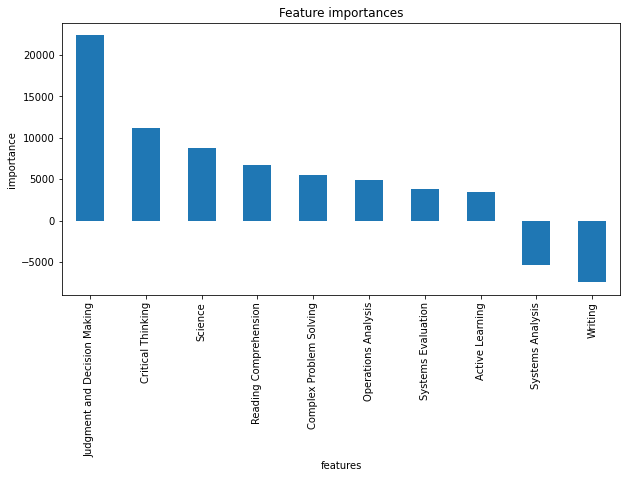

In [38]:
plt.subplots(figsize=(10, 5))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

In [39]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [40]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(14102.314810952934, 1750.014421144338)

In [41]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

15186.280308806314

In [42]:
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()